# Multiclass Text Classification using LSTM architecture
(Runs best on a TPU)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('drive/MyDrive/Multiclass Text Classification/intent.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6679 entries, 0 to 6678
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   motivos  6679 non-null   object 
 1   crec     6679 non-null   int64  
 2   cred     6679 non-null   int64  
 3   equ      6679 non-null   int64  
 4   inic     6679 non-null   int64  
 5   inv      6679 non-null   int64  
 6   mkt      6679 non-null   int64  
 7   no       6679 non-null   int64  
 8   renta    6679 non-null   int64  
 9   sueldo   6679 non-null   int64  
 10  temp     6673 non-null   float64
dtypes: float64(1), int64(9), object(1)
memory usage: 574.1+ KB


In [3]:
df['category'] = df.drop(['motivos'], axis=1).idxmax(axis=1)
df['category_id'] = df['category'].factorize()[0]
df.head()

,motivos,crec,cred,equ,inic,inv,mkt,no,renta,sueldo,temp,category,category_id
0,Crear un departamento de ventas e inversión a ...,0,0,0,0,0,1,0,0,0,0.0,mkt,0
1,establecerme en un local y agregar materia pri...,0,0,0,0,1,0,0,1,0,0.0,inv,1
2,Compra de equipo e incrementar inventario,0,0,1,0,1,0,0,0,0,0.0,equ,2
3,Invertir en crecimiento de flotilla de unidade...,0,0,1,0,0,0,0,0,0,0.0,equ,2
4,Para comprar mercancía y comprar lonas nuevas,0,0,0,0,1,0,0,0,0,0.0,inv,1


In [4]:
df.category.value_counts()

inv       2048
equ       1910
crec       601
renta      453
no         440
cred       422
inic       372
mkt        212
temp       142
sueldo      79
Name: category, dtype: int64

### Label Consolidation
En este caso no hace falta

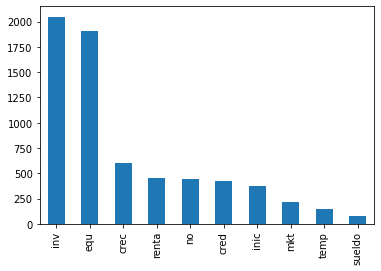

In [5]:
df['category'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.show()

## Text Pre-processing
Our text preprocessing will include the following steps:

- Convert all text to lower case.
- Replace REPLACE_BY_SPACE_RE symbols by space in text.
- Remove symbols that are in BAD_SYMBOLS_RE from text.
- Remove “x” in text.
- Remove stop words.
- Remove digits in text.

In [6]:
def print_plot(index):
    example = df[df.index == index][['motivos', 'category']].values[0]
    if len(example) > 0:
        print(example[0])
        print('category:', example[1])

In [21]:
print_plot(10)
print_plot(100)

inventario vender muebles oficina
category: inv
enganche dos autos aumentar flotilla carros uber
category: equ


A qué le llaman enganche en méjico?

In [7]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
import re

df = df.reset_index(drop=True)

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('spanish'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['motivos'] = df['motivos'].apply(clean_text)
df['motivos'] = df['motivos'].str.replace('\d+', '')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [22]:
print_plot(10)
print_plot(100)

inventario vender muebles oficina
category: inv
enganche dos autos aumentar flotilla carros uber
category: equ


## LSTM Modeling
- Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector.
- Limit the data set to the top 5,0000 words.
- Set the max number of words in each complaint at 250.

Estas cosas las tendría que **tunear**.

In [8]:
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['motivos'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7993 unique tokens.


In [9]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['motivos'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X.shape)

Shape of data tensor: (6679, 250)


### Converting categorical labels to numbers - ya está
Para la target tendría que tirar category category_id?

In [10]:
df['temp'].fillna(df['temp'].median(), inplace=True)
df.isna().sum()

motivos        0
crec           0
cred           0
equ            0
inic           0
inv            0
mkt            0
no             0
renta          0
sueldo         0
temp           0
category       0
category_id    0
dtype: int64

In [11]:
df = df.astype({"temp":'int'}) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6679 entries, 0 to 6678
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   motivos      6679 non-null   object
 1   crec         6679 non-null   int64 
 2   cred         6679 non-null   int64 
 3   equ          6679 non-null   int64 
 4   inic         6679 non-null   int64 
 5   inv          6679 non-null   int64 
 6   mkt          6679 non-null   int64 
 7   no           6679 non-null   int64 
 8   renta        6679 non-null   int64 
 9   sueldo       6679 non-null   int64 
 10  temp         6679 non-null   int64 
 11  category     6679 non-null   object
 12  category_id  6679 non-null   int64 
dtypes: int64(11), object(2)
memory usage: 678.5+ KB


In [12]:
# Y = pd.get_dummies(df['Product']).values

Y = df.drop(['motivos', 'category', 'category_id'], axis=1)
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (6679, 10)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6011, 250) (6011, 10)
(668, 250) (668, 10)


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)

print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6011, 250) (6011, 10)
(668, 250) (668, 10)


- The first layer is the embedded layer that uses 100 length vectors to represent each word.
- SpatialDropout1D performs variational dropout in NLP models.
- The next layer is the LSTM layer with 100 memory units.
- The output layer must create 13 output values, one for each class.
- Activation function is softmax for multi-class classification.
- Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.

In [17]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 50
batch_size = 64
# batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/50
85/85 [==============================] - 68s 747ms/step - loss: 2.3571 - accuracy: 0.2914 - val_loss: 2.1524 - val_accuracy: 0.3223
Epoch 2/50
85/85 [==============================] - 62s 727ms/step - loss: 2.1818 - accuracy: 0.3630 - val_loss: 1.7373 - val_accuracy: 0.5382
Epoch 3/50
85/85 [==============================] - 62s 725ms/step - loss: 1.6699 - accuracy: 0.5683 - val_loss: 1.5553 - val_accuracy: 0.5930
Epoch 4/50
85/85 [==============================] - 62s 726ms/step - loss: 1.4384 - accuracy: 0.6408 - val_loss: 1.5020 - val_accuracy: 0.6096
Epoch 5/50
85/85 [==============================] - 62s 724ms/step - loss: 1.2745 - accuracy: 0.7121 - val_loss: 1.4464 - val_accuracy: 0.6379
Epoch 6/50
85/85 [==============================] - 62s 727ms/step - loss: 1.1010 - accuracy: 0.7656 - val_loss: 1.4208 - val_accuracy: 0.6611
Epoch 7/50
85/85 [==============================] - 62s 725ms/step - loss: 1.0090 - accuracy: 0.7897 - val_loss: 1.4299 - val_accuracy: 0.6595

In [18]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

21/21 [==============================] - 1s 66ms/step - loss: 1.8133 - accuracy: 0.6228
Test set
  Loss: 1.813
  Accuracy: 0.623


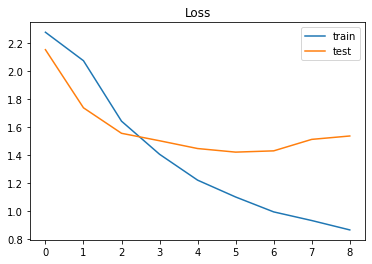

In [19]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

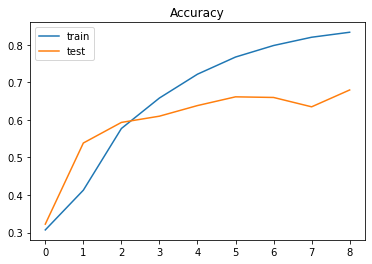

In [20]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Qué mejorar
- Comparar con lo que lograron ellos:
  - Usar precision
  - Mirar el loss score
  - Dónde pongo el weakness score
- Solucionar el overfitting
- Armar un primer documento